# Deep Neural Network (DNN)

### Import libraries

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import json
from utils import *

### Load data 

In [2]:
load=np.load(r'../data/processed/No_normalized_data_V3.npz')
keys=load.files
X_train0, y_train0, X_test0, y_test0= [load[k] for k in keys[:4]]
colsx=load['colsx']
X_train0.shape , y_train0.shape, X_test0.shape, y_test0.shape

((1063574, 16), (1063574,), (267242, 16), (267242,))

### Temporal undersampling

The data was recorded with a sampling frequency of 2Hz (sampling time of 0.5s). In this problem, we tray to predict the rotor temperature, the temperature inertia of the rotor is order of minute, so I propose to undersampling the data from Ts=500 ms to Ts=5s to fast the training of the DNN

In [3]:
X_train=X_train0[::10]
X_test=X_test0[::10]
y_train=y_train0[::10]
y_test=y_test0[::10]
X_train.shape , y_train.shape, X_test.shape, y_test.shape

((106358, 16), (106358,), (26725, 16), (26725,))

### Z normalization

In [4]:
# Input normalization 

Mean=X_train.mean(axis=0)
Xn_train=X_train-Mean
STD=Xn_train.std(axis=0)
Xn_train= Xn_train / STD

Xn_test=X_test-Mean
Xn_test= Xn_test / STD

In [5]:
# check the normalization of the data: mean must be close to 0
np.abs(Xn_train.mean(axis=0)).max(), np.abs(Xn_test.mean(axis=0)).max()

(3.7625535341026386e-16, 0.3791241789891576)

In [6]:
# check the normalization of the data: STD must be close to 1
np.abs(Xn_train.std(axis=0)).max(), np.abs(Xn_test.std(axis=0)).max()

(1.0, 1.1727066598738511)

In [7]:
# Output normalization
# We will use a tanh as activation function of the output layer 
# So I propose to centralize the output in the range [-0.9,0.9]
# [-0.9,0.9] avoid the extraime limite of the tanh [-1,1]
# In those limite the derivation is 0, so it is slow to train data when 
# the output is very close to -1/1
y_min=y_train.min()
y_max=y_train.max()
yn_train=1.8*((y_train-y_min)/(y_max-y_min)-0.5)
# check the normalization of the train set
yn_train.min(), yn_train.max()

(-0.9, 0.9)

In [8]:
yn_test=1.8*((y_test-y_min)/(y_max-y_min)-0.5)
# check the normalization of the test set
yn_test.min(), yn_test.max()

(-0.8963086086661727, 0.3961655575613971)

the max of yn_test is 0.396 instead of 0.9 because the max of y_test is 87°C and the max of y_train is 113°C: see below

In [9]:
y_test.min(),y_train.min(), y_test.max(),y_train.max()

(21.04705619812012, 20.856956481933597, 87.60704671625562, 113.55357360839844)

### Model 

In [10]:
# Creat the model 
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
for i in range(7):
    model.add(Dense(12,activation='relu'))
model.add(Dense(1,activation='tanh'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                204       
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 12)                156       
                                                                 
 dense_3 (Dense)             (None, 12)                156       
                                                                 
 dense_4 (Dense)             (None, 12)                156       
                                                                 
 dense_5 (Dense)             (None, 12)                156       
                                                                 
 dense_6 (Dense)             (None, 12)                1

In [11]:
# This checkpoint will save an intermediate model each 10 epochs
checkpoint = ModelCheckpoint('model_DNN_{epoch:03d}.h5', period=10,verbose=1) 

In [12]:
# Compile the model using Adam optimizer
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse' )

In [28]:
# Train the model
history=model.fit(Xn_train, yn_train, epochs=20, batch_size=64,
         callbacks=[checkpoint], validation_data=(Xn_test,yn_test))


Epoch 1/20
1662/1662 [==============================] - 3s 2ms/step - loss: 0.0250 - val_loss: 0.0296
Epoch 2/20
1662/1662 [==============================] - 3s 2ms/step - loss: 0.0164 - val_loss: 0.0221
Epoch 3/20
1662/1662 [==============================] - 2s 1ms/step - loss: 0.0144 - val_loss: 0.0192
Epoch 4/20
1662/1662 [==============================] - 2s 1ms/step - loss: 0.0133 - val_loss: 0.0166
Epoch 5/20
1662/1662 [==============================] - 3s 2ms/step - loss: 0.0126 - val_loss: 0.0194
Epoch 6/20
1662/1662 [==============================] - 2s 1ms/step - loss: 0.0122 - val_loss: 0.0204
Epoch 7/20
1662/1662 [==============================] - 2s 1ms/step - loss: 0.0118 - val_loss: 0.0189
Epoch 8/20
1662/1662 [==============================] - 2s 1ms/step - loss: 0.0114 - val_loss: 0.0170
Epoch 9/20
1662/1662 [==============================] - 2s 1ms/step - loss: 0.0111 - val_loss: 0.0164
Epoch 10/20
1639/1662 [============================>.] - ETA: 0s - loss: 0.0108
Ep

In [10]:
First_time=False
# If the First_time = True, we will initialize the model, fit it, and saved it 
# Otherwise, we will just load the pretrained model 
if First_time:
    # Save the model
    model.save(r'../models/DNN/model_DNN_final.h5')
    history=history.history
    json.dump( history, open( "../models/DNN/history.json", 'w' ) )
else: 
    # Load the model
    model2 = load_model(r'../models/DNN/model_DNN_final.h5')
    history = json.load( open( "../models/DNN/history.json") )

Make a beep to notify the end of model training

In [14]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 2000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

Plot the loss of the prediciton

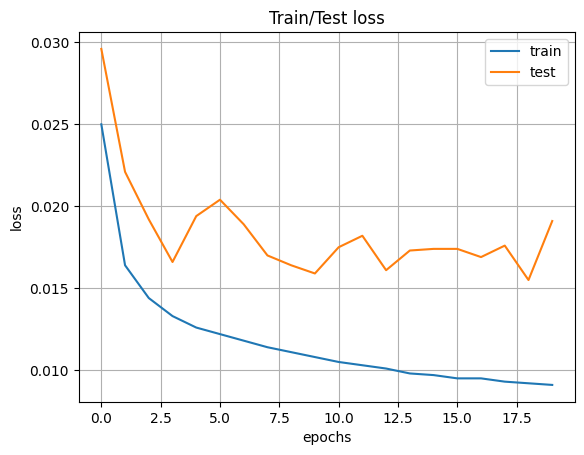

In [29]:
plt.plot(history['loss'],label='train')
plt.plot(history['val_loss'],label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train/Test loss')
plt.legend()
plt.grid()
plt.show()

### Prediction 

In [11]:
ynh_train=model2.predict(Xn_train)
ynh_test=model2.predict(Xn_test)

836/836 [==============================] - 1s 882us/step


**From the normalized output to the °C**

In [12]:
yh_test=(ynh_test.flatten()/1.8+0.5)*(y_max-y_min)+y_min
yh_train=(ynh_train.flatten()/1.8+0.5)*(y_max-y_min)+y_min

### Metrics and plot

**Train/Test set Metrics**

In [18]:
print ('_'*20,'\n','Train set')
print(local_metrics(y_train, yh_train))

print ('_'*20,'\n','Test set')
print(local_metrics(y_test, yh_test))

____________________ 
 Train set
{'r2_score': 0.9319059301052521, 'MSE': 23.95176822640016, 'RMSE': 4.8940543750963945, 'NMSE': 0.005988927218422694}
____________________ 
 Test set
{'r2_score': 0.8455059571217549, 'MSE': 50.596522986960906, 'RMSE': 7.113123293389544, 'NMSE': 0.01728099215889291}


**Real vs prediciton plot**

In [19]:
y_train, yh_train

(array([25.89539337, 25.90344429, 25.95416451, ..., 62.27448128,
        62.21632837, 62.14264575]),
 array([28.247816, 28.550337, 28.454178, ..., 59.46094 , 57.67937 ,
        57.303215], dtype=float32))

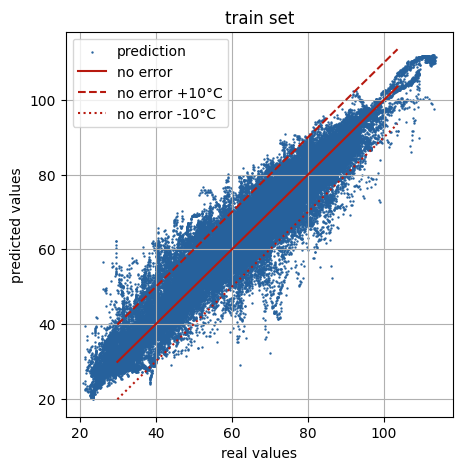

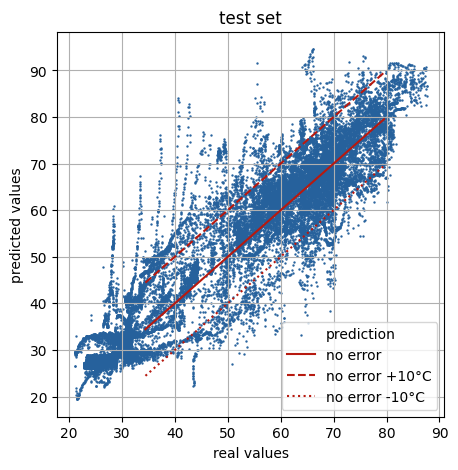

In [20]:
plot_prediction_real(y_train,yh_train,label='train set',offset=10,\
                     fig_size=(5,5))
plot_prediction_real(y_test,yh_test,label='test set',fig_size=(5,5))

**Time serie**

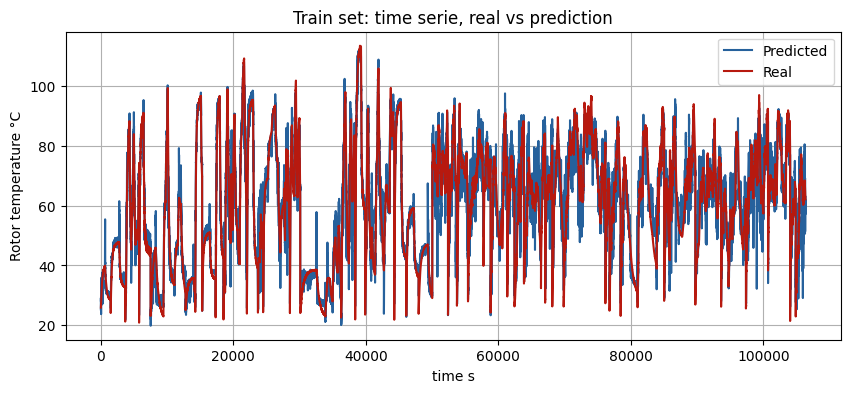

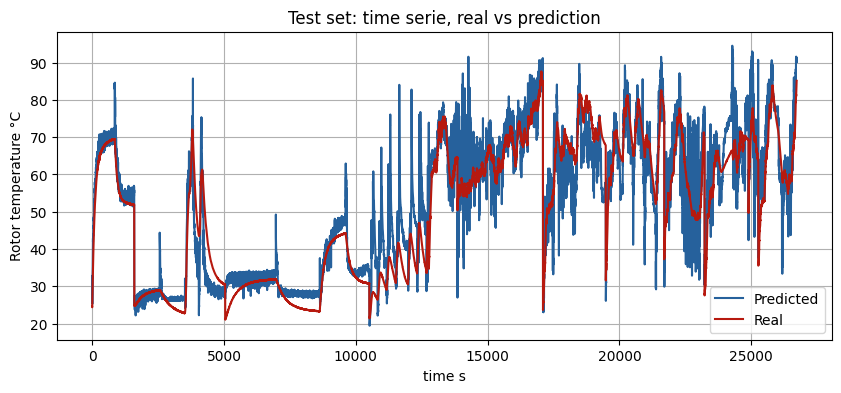

In [21]:
plot_y_yh_time(y_train,yh_train,title='Train set: time serie, real vs prediction',\
               fig_size=(10,4))
plot_y_yh_time(y_test,yh_test,title='Test set: time serie, real vs prediction',\
               fig_size=(10,4))

**Error histogram**

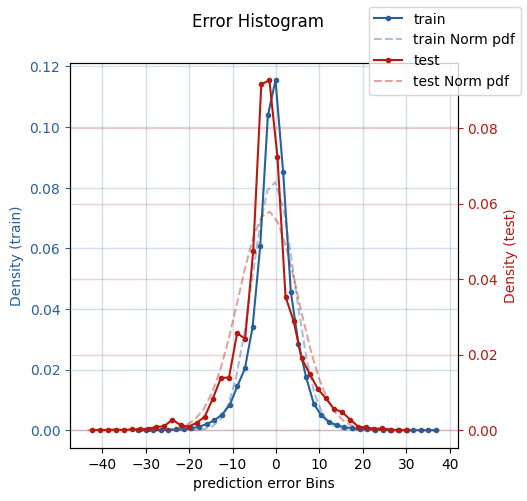

{'test': {'mean': -1.7818939510828322, 'std': 6.886318097071564}, 'train': {'mean': -0.6292989497877967, 'std': 4.853426733576612}}


In [13]:
_=plot_error(y_train, yh_train, y_test, yh_test)